# **Predicting Depression**

*Objective*
The goal of this project is to develop a predictive model to identify individuals at risk of depression based on various demographic, lifestyle, academic, and socioeconomic features. This model should ultimately aid early intervention and support.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

# EDA

In [3]:
train.shape , test.shape

((140700, 20), (93800, 19))

In [4]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [6]:
train.nunique()

id                                       140700
Name                                        422
Gender                                        2
Age                                          43
City                                         98
Working Professional or Student               2
Profession                                   64
Academic Pressure                             5
Work Pressure                                 5
CGPA                                        331
Study Satisfaction                            5
Job Satisfaction                              5
Sleep Duration                               36
Dietary Habits                               23
Degree                                      115
Have you ever had suicidal thoughts ?         2
Work/Study Hours                             13
Financial Stress                              5
Family History of Mental Illness              2
Depression                                    2
dtype: int64

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

We see above that both the test and train dataframes have some null values

In [8]:
print("There are {} duplicates in the dataset.".format(train.duplicated().sum()))

There are 0 duplicates in the dataset.


In [9]:
print("Checking for percentage of missing values in each column:")
print(train.isnull().sum() / train.shape[0] * 100, "\n\n\n")
print(test.isnull().sum() / test.shape[0] * 100)

Checking for percentage of missing values in each column:
id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental

we see above that approximately 80% of **Academic Pressure, CGPA, and Study Satisfaction** data has been left null in both the train and the test data. While this is a large amount of data, we should view what this data would suggest as these are the categories associated with education. We should also visualize if the rows are the problem or the column itself needs to be removed.

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,140700.0,70349.500000,40616.735775,0.00,35174.75,70349.50,105524.25,140699.0
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Study Satisfaction', ylabel='Count'>

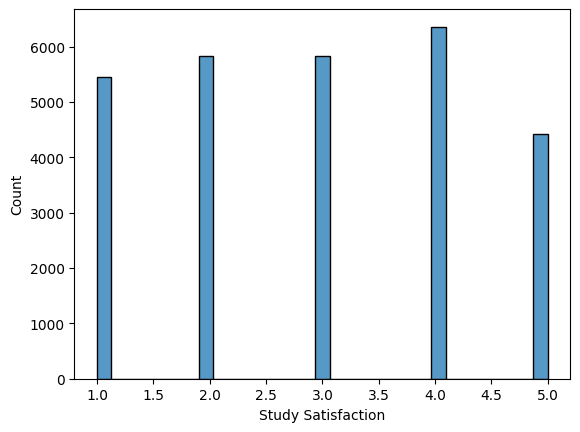

In [11]:
sns.histplot(x=train['Study Satisfaction'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Academic Pressure', ylabel='Count'>

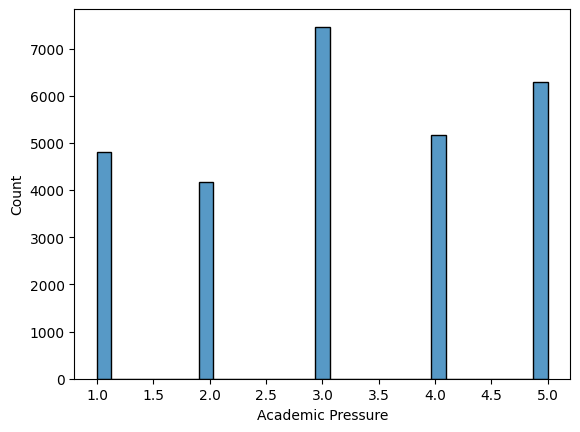

In [12]:
sns.histplot(x=train['Academic Pressure'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Work Pressure', ylabel='Count'>

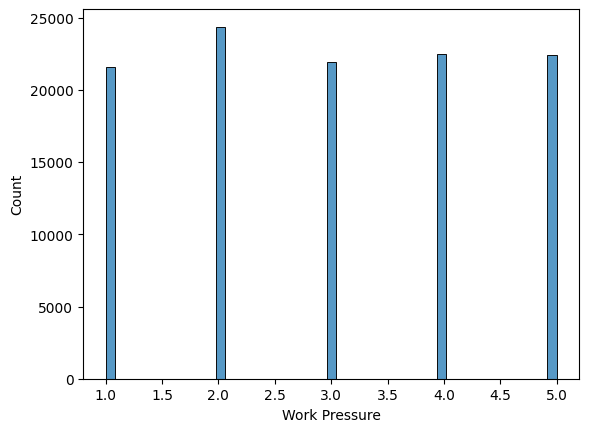

In [13]:
sns.histplot(x=train['Work Pressure'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Job Satisfaction', ylabel='Count'>

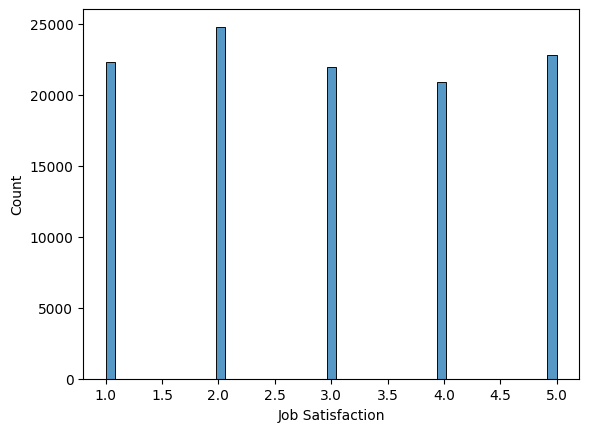

In [14]:
sns.histplot(x=train['Job Satisfaction'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Financial Stress', ylabel='Count'>

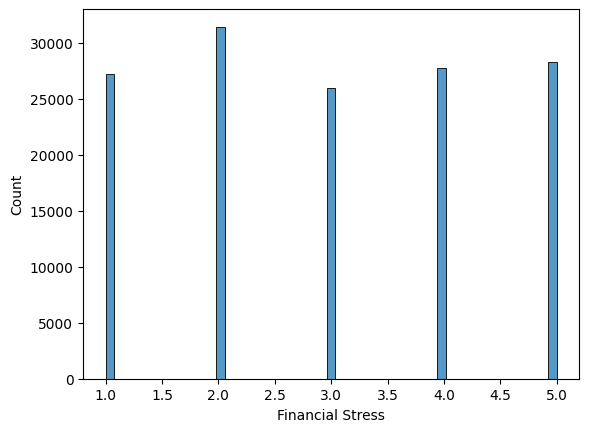

In [15]:
sns.histplot(x=train['Financial Stress'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Work/Study Hours', ylabel='Count'>

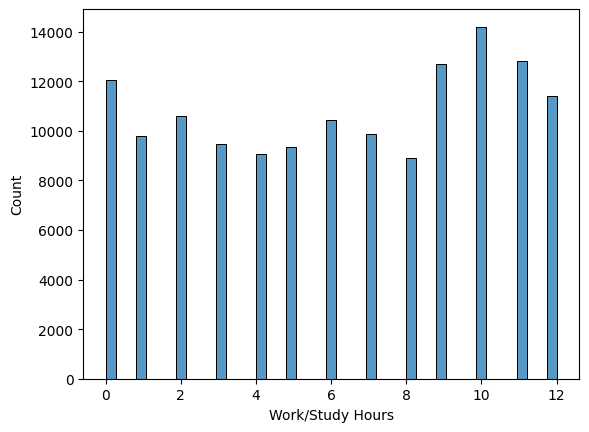

In [16]:
sns.histplot(x=train['Work/Study Hours'])

# Preprocess

In [17]:
train['Study Satisfaction'] = pd.to_numeric(train['Study Satisfaction'], errors='coerce').astype('Int64')
train['Academic Pressure'] = pd.to_numeric(train['Academic Pressure'], errors='coerce').astype('Int64')
train['Work Pressure'] = pd.to_numeric(train['Work Pressure'], errors='coerce').astype('Int64')
train['Study Satisfaction'] = pd.to_numeric(train['Study Satisfaction'], errors='coerce').astype('Int64')
train['Job Satisfaction'] = pd.to_numeric(train['Job Satisfaction'], errors='coerce').astype('Int64')
train['Work/Study Hours'] = pd.to_numeric(train['Work/Study Hours'], errors='coerce').astype('Int64')
train['Financial Stress'] = pd.to_numeric(train['Financial Stress'], errors='coerce').astype('Int64')
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,<NA>,5,NaN,<NA>,2,More than 8 hours,Healthy,BHM,No,1,2,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,<NA>,4,NaN,<NA>,3,Less than 5 hours,Unhealthy,LLB,Yes,7,3,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5,<NA>,8.97,2,<NA>,5-6 hours,Healthy,B.Pharm,Yes,3,1,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,<NA>,5,NaN,<NA>,1,Less than 5 hours,Moderate,BBA,Yes,10,1,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,<NA>,1,NaN,<NA>,1,5-6 hours,Unhealthy,BBA,Yes,9,4,Yes,0


Here we convert some float columns to int as they were whole numbers. 

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   Int64  
 8   Work Pressure                          112782 non-null  Int64  
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [19]:
test['Study Satisfaction'] = pd.to_numeric(test['Study Satisfaction'], errors='coerce').astype('Int64')
test['Academic Pressure'] = pd.to_numeric(test['Academic Pressure'], errors='coerce').astype('Int64')
test['Work Pressure'] = pd.to_numeric(test['Work Pressure'], errors='coerce').astype('Int64')
test['Study Satisfaction'] = pd.to_numeric(test['Study Satisfaction'], errors='coerce').astype('Int64')
test['Job Satisfaction'] = pd.to_numeric(test['Job Satisfaction'], errors='coerce').astype('Int64')
test['Work/Study Hours'] = pd.to_numeric(test['Work/Study Hours'], errors='coerce').astype('Int64')
test['Financial Stress'] = pd.to_numeric(test['Financial Stress'], errors='coerce').astype('Int64')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  Int64  
 8   Work Pressure                          75022 non-null  Int64  
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  Int64  
 11  Jo

In [20]:
students_train = train[train['Working Professional or Student'] == 'Student']
professional_train = train[train['Working Professional or Student'] != 'Student']
students_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5,<NA>,8.97,2,<NA>,5-6 hours,Healthy,B.Pharm,Yes,3,1,No,1
8,8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2,<NA>,5.90,5,<NA>,5-6 hours,Moderate,BSc,No,3,2,Yes,0
26,26,Aditya,Male,31.0,Srinagar,Student,NaN,3,<NA>,7.03,5,<NA>,Less than 5 hours,Healthy,BA,No,9,1,Yes,0
30,30,Prisha,Female,28.0,Varanasi,Student,NaN,3,<NA>,5.59,2,<NA>,7-8 hours,Moderate,BCA,Yes,4,5,Yes,1
32,32,Chhavi,Female,25.0,Jaipur,Student,NaN,4,<NA>,8.13,3,<NA>,5-6 hours,Moderate,M.Tech,Yes,1,1,No,0


In [21]:
professional_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,<NA>,5,NaN,<NA>,2,More than 8 hours,Healthy,BHM,No,1,2,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,<NA>,4,NaN,<NA>,3,Less than 5 hours,Unhealthy,LLB,Yes,7,3,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,<NA>,5,NaN,<NA>,1,Less than 5 hours,Moderate,BBA,Yes,10,1,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,<NA>,1,NaN,<NA>,1,5-6 hours,Unhealthy,BBA,Yes,9,4,Yes,0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,<NA>,2,NaN,<NA>,5,5-6 hours,Healthy,MCA,No,7,5,No,0


Here we see that the absence of data is due to whether the person is a student or a professional. Professionals do not have CGPAs and Students do not have work pressure. Therefore we may attempt to manipulate the data accordingly. We can first combine the pressure columns and the satisfaction columns. 

In [22]:
train['Pressure'] = train['Academic Pressure'].combine_first(train['Work Pressure'])
train['Satisfaction'] = train['Study Satisfaction'].combine_first(train['Job Satisfaction'])

In [23]:
train = train.drop(columns=['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'])

In [24]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,More than 8 hours,Healthy,BHM,No,1,2,No,0,5,2
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,Less than 5 hours,Unhealthy,LLB,Yes,7,3,No,1,4,3
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,8.97,5-6 hours,Healthy,B.Pharm,Yes,3,1,No,1,5,2
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,Less than 5 hours,Moderate,BBA,Yes,10,1,Yes,1,5,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,5-6 hours,Unhealthy,BBA,Yes,9,4,Yes,0,1,1


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   CGPA                                   27898 non-null   float64
 8   Sleep Duration                         140700 non-null  object 
 9   Dietary Habits                         140696 non-null  object 
 10  Degree                                 140698 non-null  

Now that we have combined the pressure and satisfaction columns, we can move on to the remaining columns with extensive null values: CGPA and Profession. We also have a few null values in dietary habits, degree, financial stress, pressure, and satisfaction columns.

Given the significant loss of data in the CGPA, it may be efficient to simply disregard the column rather than imputing values.

In [26]:
train = train.drop(columns=['CGPA'])

In [27]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Sleep Duration                         140700 non-null  object 
 8   Dietary Habits                         140696 non-null  object 
 9   Degree                                 140698 non-null  object 
 10  Have you ever had suicidal thoughts ?  140700 non-null  

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,1,2,No,0,5,2
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,7,3,No,1,4,3
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5-6 hours,Healthy,B.Pharm,Yes,3,1,No,1,5,2
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,10,1,Yes,1,5,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,9,4,Yes,0,1,1


In [28]:
print(train[(train['Profession'].isna()) & (train['Working Professional or Student'] == 'Working Professional')])
print(train[(train['Profession'].isna()) & (train['Working Professional or Student'] == 'Student')])

            id      Name  Gender   Age       City  \
29          29   Kashish  Female  19.0       Agra   
36          36      Anvi  Female  50.0     Kalyan   
43          43     Vidya  Female  18.0   Vadodara   
48          48     Anand    Male  38.0  Ghaziabad   
50          50    Raunak    Male  21.0       Pune   
...        ...       ...     ...   ...        ...   
140647  140647    Yuvraj    Male  35.0     Rajkot   
140655  140655     Kiran    Male  44.0     Meerut   
140666  140666  Abhishek    Male  18.0   Vadodara   
140667  140667   Kashish  Female  19.0     Rajkot   
140695  140695     Vidya  Female  18.0  Ahmedabad   

       Working Professional or Student Profession     Sleep Duration  \
29                Working Professional        NaN  More than 8 hours   
36                Working Professional        NaN          7-8 hours   
43                Working Professional        NaN  Less than 5 hours   
48                Working Professional        NaN          5-6 hours   
50 

Based on this brief look, we have 8763 rows of people who are working professionals but do not specify what sector they are in. There are also 27867 rows of students that have not filled in their profession as student. 

In [29]:
train.loc[(train['Profession'].isna()) & (train['Working Professional or Student'] == 'Student'), 'Profession'] = 'Student'

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             131937 non-null  object 
 7   Sleep Duration                         140700 non-null  object 
 8   Dietary Habits                         140696 non-null  object 
 9   Degree                                 140698 non-null  object 
 10  Have you ever had suicidal thoughts ?  140700 non-null  

In [31]:
train['Profession'].value_counts()

Profession
Student              27874
Teacher              24906
Content Writer        7814
Architect             4370
Consultant            4229
                     ...  
Dev                      1
BE                       1
B.Com                    1
Family Consultant        1
Yuvraj                   1
Name: count, Length: 64, dtype: int64

In [32]:
train['Profession'] = train['Profession'].fillna("Unspecified")

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Sleep Duration                         140700 non-null  object 
 8   Dietary Habits                         140696 non-null  object 
 9   Degree                                 140698 non-null  object 
 10  Have you ever had suicidal thoughts ?  140700 non-null  

In [34]:
train['Pressure'] = train['Pressure'].fillna(train['Pressure'].median())
train['Satisfaction'] = train['Satisfaction'].fillna(train['Satisfaction'].median())
train['Financial Stress'] = train['Financial Stress'].fillna(train['Financial Stress'].median())
train['Dietary Habits'] = train['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])
train['Degree'] = train['Degree'].fillna(train['Degree'].mode()[0])

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Sleep Duration                         140700 non-null  object 
 8   Dietary Habits                         140700 non-null  object 
 9   Degree                                 140700 non-null  object 
 10  Have you ever had suicidal thoughts ?  140700 non-null  

Lets perform these same changes on our test data. To maintains ethics, we will use values from the training set.

In [36]:
test['Pressure'] = test['Academic Pressure'].combine_first(test['Work Pressure'])
test['Satisfaction'] = test['Study Satisfaction'].combine_first(test['Job Satisfaction'])

test = test.drop(columns=['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'CGPA'])

test.loc[(test['Profession'].isna()) & (test['Working Professional or Student'] == 'Student'), 'Profession'] = 'Student'
test['Profession'] = test['Profession'].fillna("Unspecified")

test['Pressure'] = test['Pressure'].fillna(train['Pressure'].median())
test['Satisfaction'] = test['Satisfaction'].fillna(train['Satisfaction'].median())
test['Financial Stress'] = test['Financial Stress'].fillna(train['Financial Stress'].median())

test['Dietary Habits'] = test['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])
test['Degree'] = test['Degree'].fillna(train['Degree'].mode()[0])

In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             93800 non-null  object 
 7   Sleep Duration                         93800 non-null  object 
 8   Dietary Habits                         93800 non-null  object 
 9   Degree                                 93800 non-null  object 
 10  Have you ever had suicidal thoughts ?  93800 non-null  object 
 11  Wo

Now that our data is fully processed, we can continue to our next step: Modelling

# Model

In [38]:
y = train['Depression'] 
X = train.drop(['Depression', 'id', 'Name'],axis=1)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorical_columns = ['Gender', 
    'City', 
    'Working Professional or Student', 
    'Profession', 
    'Sleep Duration', 
    'Dietary Habits', 
    'Degree', 
    'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness']

categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

baseline_model = CatBoostClassifier(cat_features=categorical_features_indices, verbose=0, random_state=1)
baseline_model.fit(X_train, y_train)

val_preds = baseline_model.predict(X_val)
baseline_accuracy = accuracy_score(y_val, val_preds)
baseline_f1 = f1_score(y_val, val_preds)

print("Baseline Accuracy:", baseline_accuracy)
print("Baseline F1 Score:", baseline_f1)

Baseline Accuracy: 0.9391613361762615
Baseline F1 Score: 0.8290051937674789


In the above step, we create a baseline CatBoost Classifier model on our training data and obtain an accuracy of **93.916%**. We also achieve an F1 score of **0.8290** which is good. But we can use optuna to create a model with far better hyperparameters for our final model.

In [40]:
# Objective function with updated suggest_float syntax
def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0)
    }
    
    # Initialize CatBoost with these parameters
    model = CatBoostClassifier(cat_features=categorical_features_indices, **params, verbose=0)
    
    # Train the model and evaluate with cross-validation
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    f1 = f1_score(y_val, val_preds)  # Use F1 score as the metric for Optuna to optimize
    return f1

In [41]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

[I 2024-11-13 00:27:25,485] A new study created in memory with name: no-name-b5819ceb-1611-4fe5-ab51-334c9d0ec476
[I 2024-11-13 00:29:00,535] Trial 0 finished with value: 0.8283111422564821 and parameters: {'iterations': 561, 'depth': 9, 'learning_rate': 0.007140902613900691, 'l2_leaf_reg': 8.928636135944178, 'bagging_temperature': 0.6072119480858209, 'random_strength': 0.10782366344416121}. Best is trial 0 with value: 0.8283111422564821.
[I 2024-11-13 00:31:25,378] Trial 1 finished with value: 0.8172563249672412 and parameters: {'iterations': 664, 'depth': 10, 'learning_rate': 0.0012195323541575763, 'l2_leaf_reg': 0.5487037238399597, 'bagging_temperature': 0.42604974772963355, 'random_strength': 0.8018952354176314}. Best is trial 0 with value: 0.8283111422564821.
[I 2024-11-13 00:32:28,062] Trial 2 finished with value: 0.8228594265161354 and parameters: {'iterations': 279, 'depth': 10, 'learning_rate': 0.06521359727206259, 'l2_leaf_reg': 0.02954073058675598, 'bagging_temperature': 0.7

Trial 33 finished with value: 0.8311869821303783 and parameters: {'iterations': 577, 'depth': 4, 'learning_rate': 0.11394496114985933, 'l2_leaf_reg': 0.189636233070043, 'bagging_temperature': 0.6646862180258234, 'random_strength': 0.12072519860393123}. Best is trial 33 with value: 0.8311869821303783.

In [42]:
best_params = study.best_params
best_score = study.best_value
print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

final_model = CatBoostClassifier(cat_features=categorical_features_indices, **best_params, verbose=0)
final_model.fit(X_train, y_train)

final_val_preds = final_model.predict(X_val)
final_accuracy = accuracy_score(y_val, final_val_preds)
final_f1 = f1_score(y_val, final_val_preds)

print("Model Accuracy:", final_accuracy)
print("Model F1 Score:", final_f1)

Best F1 Score: 0.8307385229540918
Best Parameters: {'iterations': 843, 'depth': 4, 'learning_rate': 0.0618823268606148, 'l2_leaf_reg': 0.388226439237479, 'bagging_temperature': 0.33616254576755045, 'random_strength': 0.7178167763646589}
Model Accuracy: 0.939729921819474
Model F1 Score: 0.8307385229540918


After 50 trials of optuna hyperparameter tuning, we achieve the below:

Model Accuracy: 0.939907604832978
Model F1 Score: 0.8311869821303783

This model effectively achieves better results than our basemodel.

We can further attempt to improve our model with refined tuning.

In [43]:
def objective_refined(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 550, 600),
        'depth': trial.suggest_int('depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.15, 0.2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 0.75),
        'random_strength': trial.suggest_float('random_strength', 0.1, 0.2)
    }
    
    # Initialize and train CatBoost model with these refined parameters
    model = CatBoostClassifier(cat_features=categorical_features_indices, **params, verbose=0)
    
    # Train and evaluate the model
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    f1 = f1_score(y_val, val_preds)
    accuracy = accuracy_score(y_val, val_preds)
    return f1

In [44]:
# Create a new Optuna study with refined parameter ranges
study_refined = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_refined.optimize(objective_refined, n_trials=50)

[I 2024-11-13 01:21:19,730] A new study created in memory with name: no-name-b0b0773e-b77d-4674-99ff-e5d9c396c0a7
[I 2024-11-13 01:22:01,238] Trial 0 finished with value: 0.8293460925039872 and parameters: {'iterations': 593, 'depth': 4, 'learning_rate': 0.12091442004679158, 'l2_leaf_reg': 0.15036307258475765, 'bagging_temperature': 0.6209901002032141, 'random_strength': 0.1223730512189366}. Best is trial 0 with value: 0.8293460925039872.
[I 2024-11-13 01:22:49,786] Trial 1 finished with value: 0.8284660619954151 and parameters: {'iterations': 578, 'depth': 5, 'learning_rate': 0.11874544143326293, 'l2_leaf_reg': 0.19262036592520895, 'bagging_temperature': 0.6832052457728269, 'random_strength': 0.15867011936233957}. Best is trial 0 with value: 0.8293460925039872.
[I 2024-11-13 01:23:12,251] Trial 2 finished with value: 0.8299591104019148 and parameters: {'iterations': 569, 'depth': 2, 'learning_rate': 0.12698906249418662, 'l2_leaf_reg': 0.17960808502886794, 'bagging_temperature': 0.6364

Best trial:

Trial 43 finished with value: 0.8310911808669657 and parameters: {'iterations': 586, 'depth': 3, 'learning_rate': 0.16002879214800333, 'l2_leaf_reg': 0.1611898177151389, 'bagging_temperature': 0.513842784496157, 'random_strength': 0.14862405627394454}. Best is trial 43 with value: 0.8310911808669657.

In [45]:
# Print the best results from the refined search
best_params_refined = study_refined.best_params
best_f1_refined = study_refined.best_value
print("Best F1 Score from Refined Search:", best_f1_refined)
print("Best Parameters from Refined Search:", best_params_refined)

Best F1 Score from Refined Search: 0.8310083698684734
Best Parameters from Refined Search: {'iterations': 596, 'depth': 3, 'learning_rate': 0.12513386706360402, 'l2_leaf_reg': 0.18592112758210189, 'bagging_temperature': 0.5638731263032535, 'random_strength': 0.16727110506466702}


In [46]:
final_model_refined = CatBoostClassifier(cat_features=categorical_features_indices, **best_params_refined, verbose=0)
final_model_refined.fit(X_train, y_train)
final_val_preds = final_model_refined.predict(X_val)
final_accuracy = accuracy_score(y_val, final_val_preds)
final_f1 = f1_score(y_val, final_val_preds)

print("Final Model Accuracy:", final_accuracy)
print("Final Model F1 Score:", final_f1)

Final Model Accuracy: 0.939729921819474
Final Model F1 Score: 0.8310083698684734


With our second iteration of optuna optimization we get:

Model Accuracy: 0.9397654584221748 Model F1 Score: 0.8310911808669657


we can train our model on our full training set.

In [47]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

final_model = CatBoostClassifier(cat_features=categorical_features_indices, **best_params_refined, verbose=0)
final_model.fit(X_full, y_full)

We can now apply our model to our unseen test set.

In [48]:
test = test.drop(['id', 'Name'], axis=1)

In [49]:
test_preds = final_model.predict(test)

# Assign the predictions to the 'Depression' column in the sample submission
sample_submission['Depression'] = test_preds

# Save the final submission file
sample_submission.to_csv('submission.csv', index=False)

# Preview the submission file to ensure it's structured correctly
sample_submission.head(10)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
5,140705,0
6,140706,0
7,140707,0
8,140708,0
9,140709,1


In [50]:
feature_importances = final_model.get_feature_importance(prettified=True)
print(feature_importances)

final_model.save_model("catboost_final_model.cbm")

                               Feature Id  Importances
0                                     Age    45.594156
1   Have you ever had suicidal thoughts ?    16.998268
2                                Pressure     9.530660
3                        Financial Stress     7.124144
4                            Satisfaction     5.411795
5         Working Professional or Student     5.169281
6                        Work/Study Hours     3.467582
7                          Dietary Habits     2.350677
8                              Profession     1.966142
9                          Sleep Duration     1.010122
10                                 Degree     0.800516
11                                   City     0.404493
12       Family History of Mental Illness     0.151568
13                                 Gender     0.020596
